# Desafío Kaggle: Clasificación Jerárquica de Imágenes de Animales

## Descripción del Desafío

La tarea consiste en clasificar imágenes de animales siguiendo una estructura jerárquica de categorías, que incluye niveles como clase general (por ejemplo, mamífero, ave, reptil) y especie específica (por ejemplo: perro, pavo o cocodrilo).

Para abordar este problema, utilizaremos técnicas de procesamiento de imágenes mediante redes neuronales convolucionales (CNN) y estrategias que aprovechan la estructura jerárquica de las etiquetas, permitiendo que el modelo aprenda tanto las características visuales generales como las particularidades de cada especie.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from PIL import Image

### Descripción del Dataset y Análisis Exploratorio

El dataset utilizado consiste en imágenes de animales clasificadas de forma jerárquica. Cada imagen está etiquetada tanto con una **categoría general** (por ejemplo, "mamífero", "ave") como con una **clase específica** (por ejemplo, "perro", "gato", "águila").

Para la carga de la información se utiliza el archivo  `train.csv` que contiene los nombres de los archivos de imagen y sus correspondientes etiquetas (general y específica) y el archivo `.npy` llamado `dict.npy` que permite traducir los IDs de clase en nombres legibles.

In [ ]:
# Cargar archivo dict.npy
class_dict = np.load("dict.npy", allow_pickle=True).item()
class_dict = {int(k): v for k, v in class_dict.items()}

print("Diccionario cargado:")

# Leer CSV del train y separar columnas
df = pd.read_csv('train.csv')
print(df.head())

Diccionario cargado:
            Id Expected
0  image_0.jpg      0 5
1  image_1.jpg      0 5
2  image_2.jpg      0 5
3  image_3.jpg      0 5
4  image_4.jpg      0 5


In [ ]:
df[['clase_general', 'clase_especifica']] = df['Expected'].str.split(' ', expand=True)
df['clase_general'] = df['clase_general'].astype(int)
df['clase_especifica'] = df['clase_especifica'].astype(int)

df = df.drop(columns=['Expected'])  # Elimina la columna original

# Número de clases
n_general = df['clase_general'].nunique()
n_especifica = df['clase_especifica'].nunique()

print(f'Categoría general: {n_general}')
print(f'Categoría específica: {n_especifica}')

Categoría general: 5
Categoría específica: 32


A continuación se analiza la distribución de ejemplos por clase general para entender posibles desbalances en el dataset.
Se observa que las clases están algo desbalanceadas sobre la clase más general, pero sobre la especie específica se puede notar un promedio un poco más equilibrado. Aún así, hay una clase con muchos ejemplos (Tortuga) y una con muy pocos (Gusano)

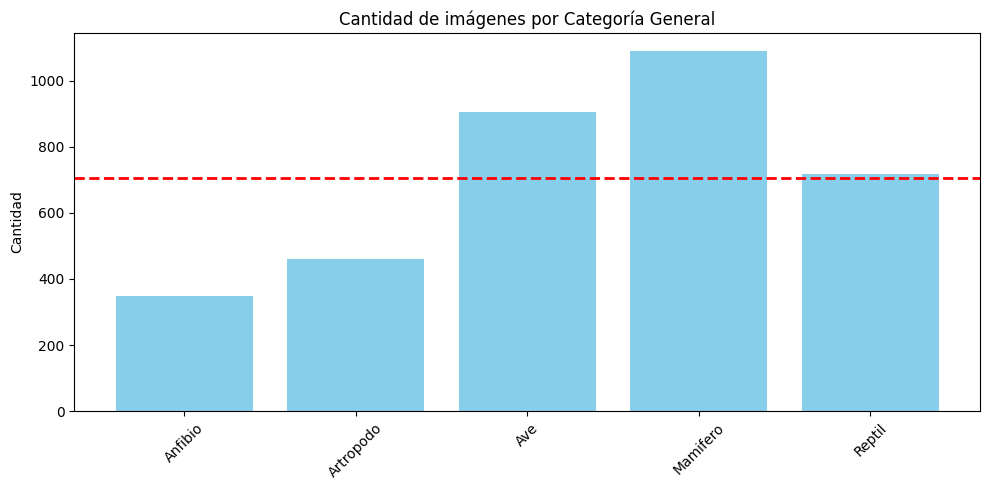

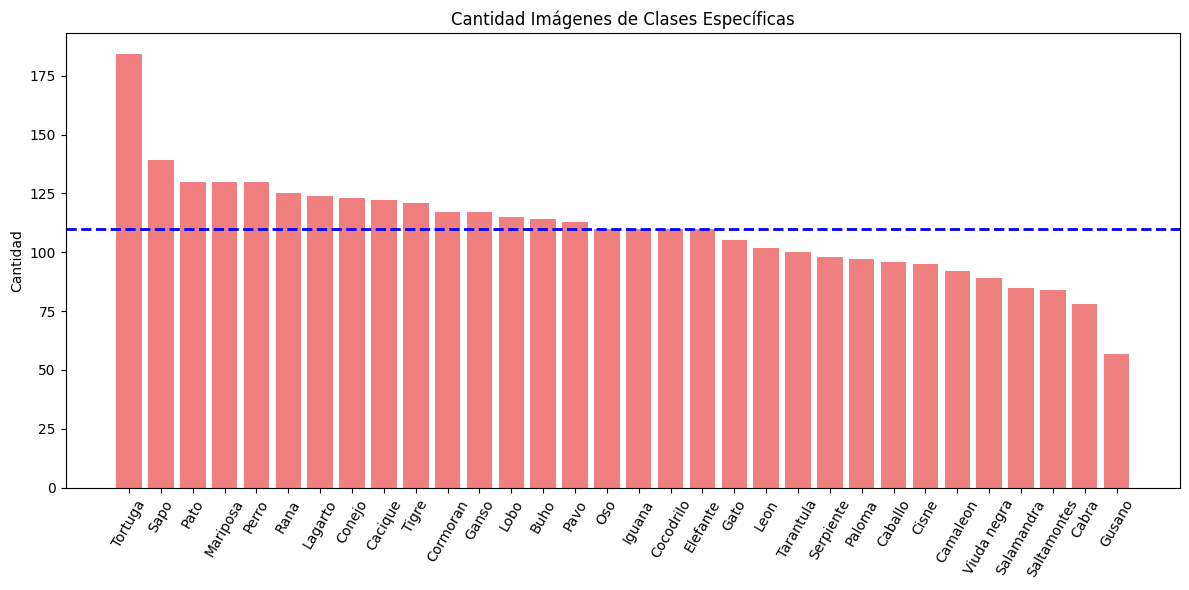

In [ ]:
# Conteo por categoría general
conteo_general = df['clase_general'].value_counts().sort_index()
conteo_general = pd.DataFrame({
    'Id': conteo_general.index,
    'Nombre': [class_dict[i] for i in conteo_general.index],
    'Cantidad': conteo_general.values
})
# Conteo por clase específica
conteo_especifica = df['clase_especifica'].value_counts().sort_index()
conteo_especifica = pd.DataFrame({
    'Id': conteo_especifica.index,
    'Nombre': [class_dict[i] for i in conteo_especifica.index],
    'Cantidad': conteo_especifica.values
})
# Gráfico 1: Cantidad por categoría general
plt.figure(figsize=(10, 5))

# Línea del promedio
promedio_general = conteo_general['Cantidad'].mean()
plt.axhline(promedio_general, color='red', linestyle='--', linewidth=2, label=f'Promedio: {promedio_general:.1f}')
plt.bar(conteo_general['Nombre'], conteo_general['Cantidad'], color='skyblue')
plt.title('Cantidad de imágenes por Categoría General')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico 2: Cantidad por clase específica
conteo_top = conteo_especifica.sort_values(by='Cantidad', ascending=False).head(40)
plt.figure(figsize=(12, 6))
plt.bar(conteo_top['Nombre'], conteo_top['Cantidad'], color='lightcoral')
promedio_top = conteo_top['Cantidad'].mean()
plt.axhline(promedio_top, color='blue', linestyle='--', linewidth=2, label=f'Promedio: {promedio_top:.1f}')
plt.title('Cantidad Imágenes de Clases Específicas')
plt.ylabel('Cantidad')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

#### Carga y visualización de Imágenes

Se define una función de carga y una de visualización de imágenes que permite inspeccionar el contenido del dataset y validar visualmente los datos.

In [ ]:
def cargar_imagen(nombre_archivo, image_dir, size=(224, 224)):
    ruta = os.path.join(image_dir, nombre_archivo)
    img = Image.open(ruta).convert('RGB')
    img = img.resize(size)
    return img

def mostrar_imagenes(df, image_dir, n=5):
    muestras = df.sample(n)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i, (_, fila) in enumerate(muestras.iterrows()):
        img = cargar_imagen(fila['Id'], image_dir)
        # Usar el diccionario para traducir los IDs
        nombre_general = class_dict.get(int(fila['clase_general']), str(fila['clase_general']))
        nombre_especifica = class_dict.get(int(fila['clase_especifica']), str(fila['clase_especifica']))
        axs[i].imshow(img)
        axs[i].set_title(f"{nombre_general}\n{nombre_especifica}")
        axs[i].axis('off')
    plt.show()

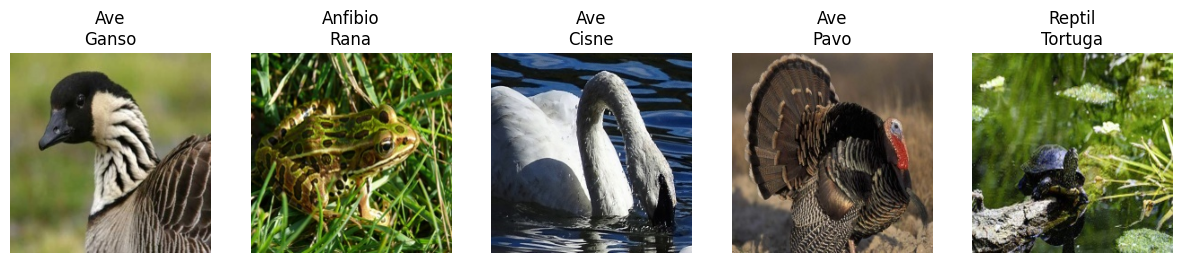

In [ ]:
# Ruta de las imágenes
image_dir = 'Train/'

# Visualizar ejemplos
mostrar_imagenes(df, image_dir)

#### Preparación del Dataset

A continuación se definen funciones para convertir el dataset original en un formato adecuado para ser utilizado en modelos con Keras/TensorFlow. En esta sección se realiza lo siguiente:
- Convertir las imágenes en tensores con el tamaño y tipo de datos apropiado.
- Codificar las etiquetas generales y específicas usando codificación one-hot, adecuada para problemas de clasificación multiclase.
- Agrupar los datos en batches utilizando `tf.data.Dataset`, una API de TensorFlow que permite realizar entrenamiento por lotes para optimizar el rendimiento.

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def imagen_tensor_resnet(imagen_pil):
    img_array = np.array(imagen_pil)
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_array = tf.image.resize(img_array, [224, 224])
    return img_array


def crear_dataset(df, image_dir, num_clases_general, num_clases_especifica):
    X = []
    y_general = []
    y_especifica = []

    le_especifica = LabelEncoder()
    le_especifica.fit(df['clase_especifica'])

    le_general = LabelEncoder()
    le_general.fit(df['clase_general'])

    for _, fila in df.iterrows():
        img = cargar_imagen(fila['Id'], image_dir)
        tensor = imagen_tensor_resnet(img)
        X.append(tensor)

        y_general.append(le_general.transform([fila['clase_general']])[0])
        y_especifica.append(le_especifica.transform([fila['clase_especifica']])[0])

    X = tf.stack(X)
    y_general = tf.convert_to_tensor(to_categorical(y_general, num_classes=num_clases_general))
    y_especifica = tf.convert_to_tensor(to_categorical(y_especifica, num_classes=num_clases_especifica))
    return X, (y_general, y_especifica)

def crear_tf_dataset(X, y_tuple, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y_tuple))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

#### División del Dataset y Preparación de Datos para Entrenamiento

Para evaluar correctamente el desempeño del modelo, se requiere dividir el dataset original en un conjunto de entrenamiento y otro de validación. En el contexto de la clasificación jerárquica, esta división debe considerar no solo la distribución de clases generales o específicas por separado, sino también su combinación.

Por ello, se utiliza una estrategia de **estratificación compuesta**, que garantiza que la proporción de cada combinación de clase general y clase específica se mantenga en ambas particiones del dataset.

Una vez divididos los datos, se procede a procesarlos para transformarlos en tensores listos para el entrenamiento con las funciones descritas anteriormente.

El resultado son dos datasets preparados:
- `train_ds`: dataset de entrenamiento, mezclado aleatoriamente.
- `val_ds`: dataset de validación, no mezclado para garantizar evaluaciones consistentes.


In [ ]:
#Dividir en train y validación con ambas clases estratificadas

from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    stratify=df['clase_general'].astype(str) + "_" + df['clase_especifica'].astype(str),
    random_state=42
)

#Dataset normalizado con one-hot
X_train, y_train = crear_dataset(df_train, image_dir, n_general, n_especifica)
X_val, y_val = crear_dataset(df_val, image_dir, n_general, n_especifica)

#Crea dataset por batch
train_ds = crear_tf_dataset(X_train, y_train, batch_size=32)
val_ds = crear_tf_dataset(X_val, y_val, batch_size=32, shuffle=False)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet50 import preprocess_input

#### Data Augmentation

En esta tarea se define una capa de aumento de datos que se aplica directamente sobre los tensores de entrada, usando la API de capas de Keras. Esto permite que cada imagen del batch sea modificada dinámicamente en cada época, sin necesidad de almacenar múltiples versiones en disco.

#### Transformaciones Aplicadas

La capa `data_augmentation` incluye las siguientes operaciones:

- **Volteo horizontal** (`RandomFlip`): simula que el animal mira hacia el otro lado.
- **Rotación aleatoria** (`RandomRotation`): permite pequeñas rotaciones (hasta 36°), útil para imágenes que no estén perfectamente alineadas.
- **Zoom** (`RandomZoom`): acerca o aleja la imagen en hasta un 10%.
- **Traslación** (`RandomTranslation`): desplaza la imagen horizontal y verticalmente, útil para tolerar pequeñas variaciones de ubicación.
- **Contraste** (`RandomContrast`): simula condiciones de iluminación variables.

Estas transformaciones actúan exclusivamente durante el entrenamiento. Durante la validación y prueba, las imágenes se mantienen sin modificaciones para evaluar el rendimiento real del modelo.


In [ ]:
def data_augmentation():
    return Sequential([
        layers.RandomFlip("horizontal"),         # Voltea animales horizontalmente (como mirar en otra dirección)
        layers.RandomRotation(0.1),              # Rota hasta 36° (0.1 * 360)
        layers.RandomZoom(0.1),                  # Zoom in/out hasta 10%
        layers.RandomTranslation(0.1, 0.1),      # Traslada hasta un 10% en x e y
        layers.RandomContrast(0.1)               # Cambia el contraste para simular distintos entornos de luz
    ], name="data_augmentation")

#### Modelo Jerárquico con Salidas Múltiples

Para resolver esta tarea de clasificación se utiliza una arquitectura de red neuronal convolucional con **salidas múltiples jerárquicas**, basada en el enfoque utilizado en la literatura: B-CNN (Branch Convolutional Neural Network) [1]. La idea central es compartir una base convolucional común que extrae características visuales generales, y luego llevar la red a dos salidas especializadas para cada nivel jerárquico.

#### Base del Modelo: ResNet50 + ImageNet

La arquitectura se construye utilizando como backbone el modelo **ResNet50** [2] preentrenado en **ImageNet** [3]. Este backbone actúa como **extractor de características**, permitiendo reutilizar conocimiento visual general aprendido en millones de imágenes.

Algunas razones por las que se selecciona esta arquitectura:

- **Transferencia de aprendizaje**: usar pesos preentrenados acelera la convergencia y mejora el rendimiento.
- **Compatibilidad jerárquica**: las características extraídas por ResNet50 capturan tanto formas generales como detalles finos, lo que es crucial para distinguir entre clases específicas dentro de una categoría general.

#### Estructura de la Red

El modelo se compone de tres bloques principales:

1. **Extractor convolucional**: se usa ResNet50 sin su capa de clasificación final y con sus pesos "congelados" para obtener una representación profunda de las imágenes.
2. **Cuerpo denso común**: se agregan capas densas intermedias con normalización y dropout para adaptar las características extraídas a las tareas específicas y evitar sobreajuste.
3. **Dos ramas de salida**:
   - Una capa densa con softmax para predecir la **clase general**.
   - Otra capa densa con softmax para predecir la **clase específica**.

Esta estructura permite al modelo aprender simultáneamente dos funciones objetivo relacionadas.

#### Este desarrollo se basa en:

- **ImageNet + ResNet50**: Resnet50 es una arquitectura CNN de 50 capas que utiliza skip connections para facilitar el entrenamiento [2]. Se utilizan los pesos de esta red entrenada para el dataset ImageNet [3]
- **B-CNN**: Red jerárquica de doble salida basada en ramificación [1]. Las estrategias y la construcción del modelo está basada en el modelo implementado en esta referencia, utilizando pesos dinámicos para la función de pérdida de cada salida.

---

**Referencias:**

[1] Zhu, M., & Bain, M. (2017). *B-CNN: Branch Convolutional Neural Network for Hierarchical Classification*. arXiv:1709.09890.

[2] He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Deep Residual Learning for Image Recognition*. arXiv:1512.03385.

[3] Deng, J., Dong, W., Socher, R., Li, L.-J., Li, K., & Fei-Fei, L. (2009). *ImageNet: A Large-Scale Hierarchical Image Database*. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), pp. 248–255. https://doi.org/10.1109/CVPR.2009.5206848

In [ ]:
# Parámetros entrada
IMAGE_SIZE = (224, 224, 3)
NUM_CATEGORIAS = n_general        # 5
NUM_CLASES = n_especifica         # 32

# Entrada
inputs = Input(shape=IMAGE_SIZE)

# Bloque preprocesamiento
x = data_augmentation()(inputs)         # data augmentation
x = preprocess_input(x)                 # normalización de la entrada específica para ResNet50

# Modelo base (pre entrenado)
base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False  # congelar pesos

# Modelo base le paso x (input preprocesada)
x = base_model(x, training=False)

# Ver información del modelo
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#Cuerpo común del modelo

# Reducción
x = GlobalAveragePooling2D()(x)

# Bloque denso estilo paper para ambas salidas (solo modifico cant de neuronas)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Salida jerárquica 1: categoría general
sal_gen = Dense(NUM_CATEGORIAS, activation='softmax', name='clase_general')(x)

# Salida jerárquica 2: clase específica
sal_esp = Dense(NUM_CLASES, activation='softmax', name='clase_especifica')(x)

# Modelo final
modelo = Model(inputs=inputs, outputs=[sal_gen, sal_esp])

#### Pérdida Compuesta con Pesos Dinámicos

En clasificación jerárquica, se utiliza una pérdida compuesta que combina las salidas general y específica:

$$
\text{Loss total} = \alpha \cdot \text{Loss}_{\text{general}} + \gamma \cdot \text{Loss}_{\text{específica}}
$$

Donde $\alpha$ y $\gamma$ son coeficientes que controlan la importancia de cada pérdida.

La estrategia consiste en ajustar dinámicamente estos coeficientes durante el entrenamiento:

- Al inicio se prioriza la clase general.
- Luego, el foco se transfiere progresivamente a la clase específica.

Se implementa mediante un `Callback` de Keras que actualiza los valores de $\alpha$ y $\gamma$ en cada época.



In [ ]:
from tensorflow.keras import backend as K

#En paper se implementa loss weights dinámicos BT-Strategy
class LossWeightsModifier(tf.keras.callbacks.Callback):
    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma

    def on_epoch_end(self, epoch, logs=None):
        if epoch < 5:
            K.set_value(self.alpha, 0.4)
            K.set_value(self.gamma, 0.6)
        elif epoch < 10:
            K.set_value(self.alpha, 0.2)
            K.set_value(self.gamma, 0.8)
        else:
            K.set_value(self.alpha, 0.05)
            K.set_value(self.gamma, 0.95)

#### Configuración del Entrenamiento

El modelo se compila con pérdidas cruzadas para ambas salidas, usando pesos dinámicos $\alpha$ y $\gamma$ ajustados por un callback. Se entrena con `SGD` con momentum, y se usa `EarlyStopping` para detener cuando no mejora la precisión en validación de la clase específica.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers


# Variables globales para loss weights
alpha = K.variable(0.98, dtype='float32', name='alpha')  # clase_general
gamma = K.variable(0.02, dtype='float32', name='gamma')  # clase_especifica
change_lw = LossWeightsModifier(alpha, gamma)

early_stop = EarlyStopping(
    monitor='val_clase_especifica_accuracy',
    patience=7,
    min_delta=0.001,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

#optimizer = optimizers.Adam(learning_rate=0.001)
optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

modelo.compile(
    optimizer=optimizer,
    loss=['categorical_crossentropy', 'categorical_crossentropy'],
    loss_weights=[alpha, gamma],
    metrics=['accuracy', 'accuracy']
)

#### Entrenamiento del Modelo

Se entrena el modelo utilizando los datasets previamente creados (`train_ds` y `val_ds`), integrando los callbacks para pesos dinámicos (`LossWeightsModifier`) y detención temprana (`EarlyStopping`). El entrenamiento se adapta progresivamente, enfocándose primero en la clase general y luego en la específica.

In [ ]:
history = modelo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    callbacks=[early_stop, change_lw]
)

import pickle

# Guarda el historial completo (epoch a epoch)
with open("history5.pkl", "wb") as f:
    pickle.dump(history.history, f)

#Guardar el modelo
modelo.save('modelo_entrenado8.keras')


Epoch 1/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - clase_especifica_accuracy: 0.0445 - clase_especifica_loss: 4.8551 - clase_general_accuracy: 0.4913 - clase_general_loss: 1.5719 - loss: 1.6374 - val_clase_especifica_accuracy: 0.0511 - val_clase_especifica_loss: 3.5793 - val_clase_general_accuracy: 0.9475 - val_clase_general_loss: 0.1747 - val_loss: 0.2493
Epoch 2/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - clase_especifica_accuracy: 0.0993 - clase_especifica_loss: 4.0711 - clase_general_accuracy: 0.8556 - clase_general_loss: 0.4180 - loss: 2.6097 - val_clase_especifica_accuracy: 0.6936 - val_clase_especifica_loss: 1.2321 - val_clase_general_accuracy: 0.9532 - val_clase_general_loss: 0.1464 - val_loss: 0.8302
Epoch 3/500
89/89 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - clase_especifica_accuracy: 0.4368 - clase_especifica_loss: 2.0580 - clase_general_accuracy: 0.8764 - clase_general_loss: 0.3673 - loss: 1.3814 - val_clase_especifica_accuracy: 0.8340 - val_clase_especifica_loss: 0.6553 - v

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el historial y el modelo si se pierde ejecución

with open("history5.pkl", "rb") as f:
    history = pickle.load(f)

modelo = load_model("modelo_entrenado8.keras")

#### Resultados por Época

Durante el entrenamiento, se registraron las precisiones (`accuracy`) por época para ambas salidas del modelo:

- **Clase General**: alcanzó altos niveles de precisión en pocas épocas, lo cual es esperable ya que las categorías generales presentan diferencias visuales más marcadas (por ejemplo, “ave” vs. “mamífero”).
- **Clase Específica**: mostró una curva de aprendizaje más lenta, pero fue mejorando a medida que aumentaba el peso $\gamma$ en la función de pérdida, siguiendo la estrategia BT-Strategy.

Este comportamiento confirma que el modelo primero aprende a distinguir categorías amplias y, una vez establecida esta base, logra refinar su capacidad para reconocer clases más detalladas.



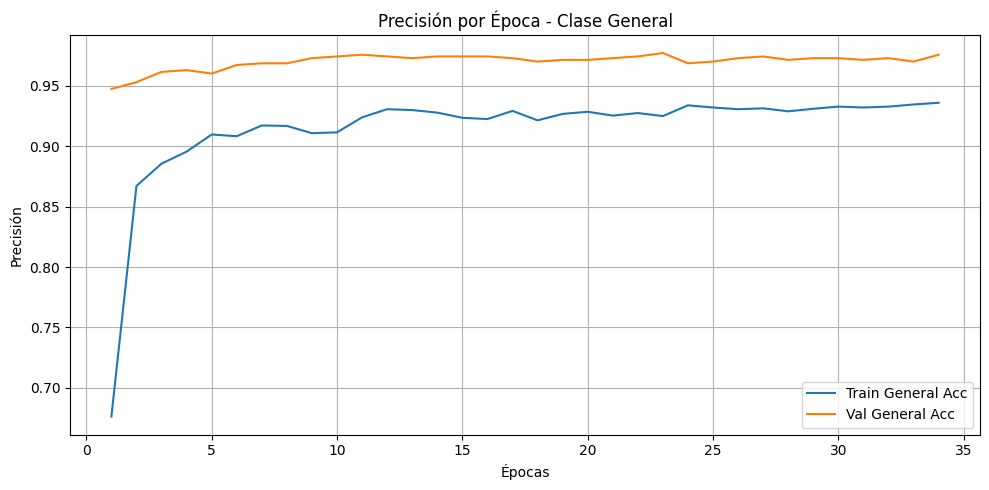

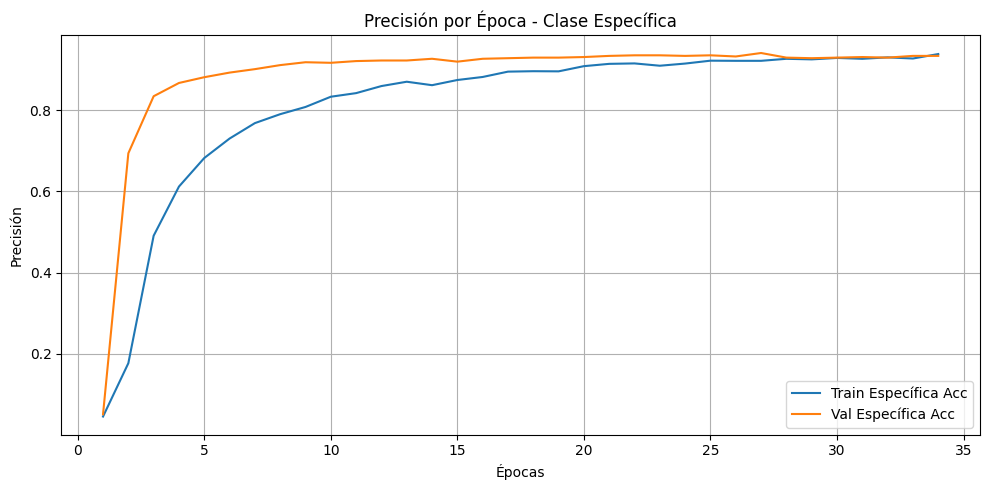

In [ ]:
# Si uso el historial guardado usar solo history
# Graficar precisión de clase general

epochs = range(1, len(history.history['clase_general_accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['clase_general_accuracy'], label='Train General Acc')
plt.plot(epochs, history.history['val_clase_general_accuracy'], label='Val General Acc')
plt.title('Precisión por Época - Clase General')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar precisión de clase específica
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['clase_especifica_accuracy'], label='Train Específica Acc')
plt.plot(epochs, history.history['val_clase_especifica_accuracy'], label='Val Específica Acc')
plt.title('Precisión por Época - Clase Específica')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, f1_score, recall_score

# Obtener predicciones del modelo
pred_gen, pred_esp = modelo.predict(val_ds)

# Convertir a clases predichas
y_pred_gen = np.argmax(pred_gen, axis=1)
y_pred_esp = np.argmax(pred_esp, axis=1)

# Obtener clases verdaderas desde el dataset
y_true_gen = []
y_true_esp = []

for _, (y_batch_gen, y_batch_esp) in val_ds:
    y_true_gen.extend(np.argmax(y_batch_gen.numpy(), axis=1))
    y_true_esp.extend(np.argmax(y_batch_esp.numpy(), axis=1))

y_true_gen = np.array(y_true_gen)
y_true_esp = np.array(y_true_esp)

# ---- MÉTRICAS ----

print("\nCATEGORÍA GENERAL")
print(classification_report(y_true_gen, y_pred_gen, zero_division=0))

acc_gen = np.mean(y_true_gen == y_pred_gen)
f1_gen = f1_score(y_true_gen, y_pred_gen, average='macro', zero_division=0)
recall_gen = recall_score(y_true_gen, y_pred_gen, average='macro', zero_division=0)

print(f"Accuracy general: {acc_gen:.4f}")
print(f"F1 macro general: {f1_gen:.4f}")
print(f"Recall macro general: {recall_gen:.4f}")

print("\nCLASE ESPECÍFICA")
print(classification_report(y_true_esp, y_pred_esp, zero_division=0))

acc_esp = np.mean(y_true_esp == y_pred_esp)
f1_esp = f1_score(y_true_esp, y_pred_esp, average='macro', zero_division=0)
recall_esp = recall_score(y_true_esp, y_pred_esp, average='macro', zero_division=0)

print(f"Accuracy específica: {acc_esp:.4f}")
print(f"F1 macro específica: {f1_esp:.4f}")
print(f"Recall macro específica: {recall_esp:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step

CATEGORÍA GENERAL
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        70
           1       0.97      0.98      0.97        92
           2       1.00      1.00      1.00       181
           3       1.00      1.00      1.00       218
           4       0.94      0.94      0.94       144

    accuracy                           0.97       705
   macro avg       0.97      0.96      0.96       705
weighted avg       0.97      0.97      0.97       705

Accuracy general: 0.9745
F1 macro general: 0.9642
Recall macro general: 0.9632

CLASE ESPECÍFICA
              precision    recall  f1-score   support

           0       0.76      0.88      0.81        25
           1       1.00      0.71      0.83        17
           2       0.88      0.82      0.85        28
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        26
           5       1.00      1.

#### Análisis de Métricas por Clase

Los resultados muestran un rendimiento muy bueno tanto en las predicciones de **categoría general** como en las de **clase específica**.

####  Categoría General

- Accuracy general: **97.45%**
- F1 macro: **96.42%**

El modelo logra distinguir con gran precisión entre las categorías generales, con F1-scores perfectos (1.00) en las clases Mamífero y Ave, sin embargo, le cuesta las clases Anfibio y Reptil (0.91 y 0.94).  

####  Clase Específica

- Accuracy específica: **94.04%**
- F1 macro: **94.22%**

El rendimiento en clases específicas también es muy sólido. No obstante, algunas clases muestran mayor dificultad:

- Clases con **menor F1-score**:
  - Lagarto (29): F1 = **0.77**
  - Rana (0): F1 = **0.81**
  - Camaleón (26): F1 = **0.81**
  - Salamandra (1): F1 = **0.83** (recall más bajo: 0.71)
  - Iguana (28): F1 = **0.85**

In [ ]:
#@title Matrices de Confusión

import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title="Matriz de Confusión", class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title(title)
    plt.tight_layout()
    plt.show()

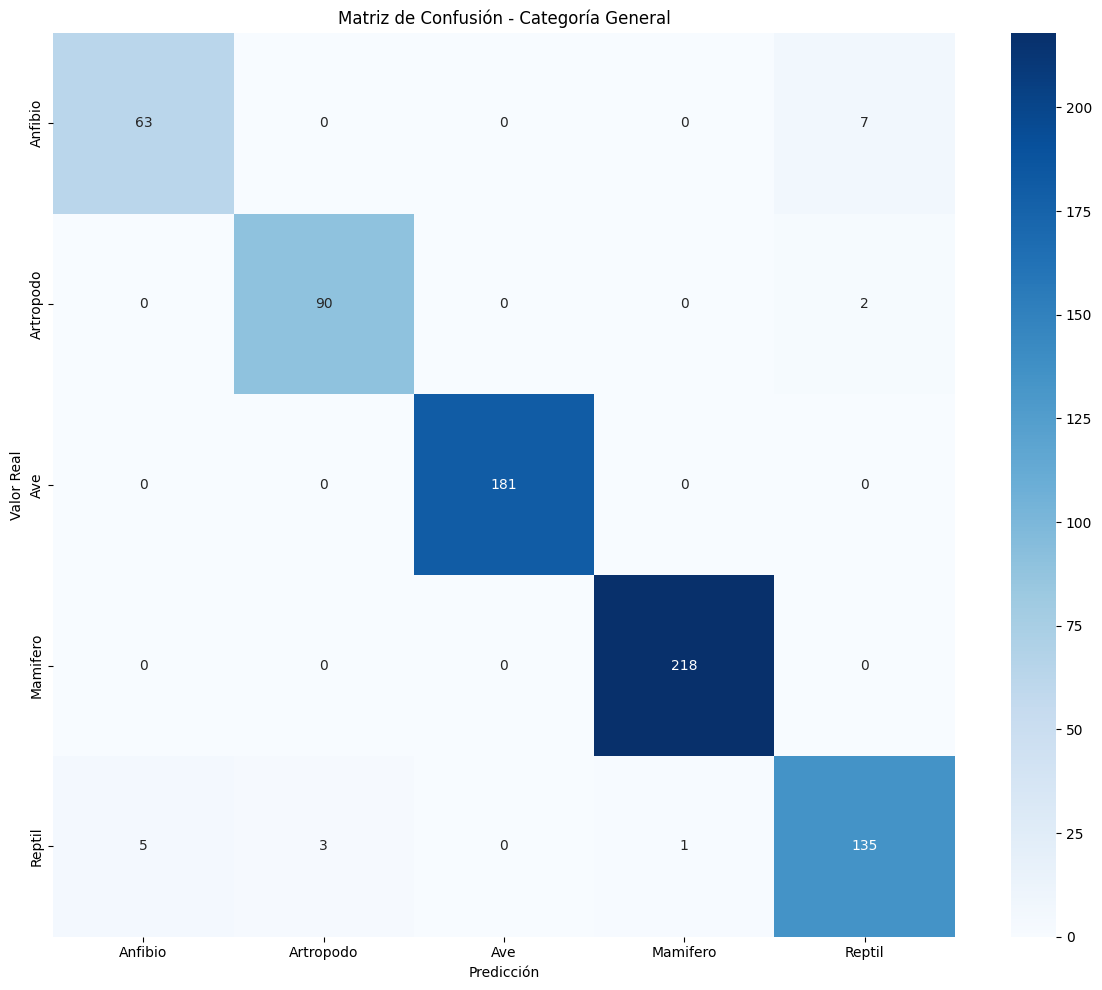

In [ ]:
# nombres de clases desde dict.npy
class_names_gen = [class_dict[i] for i in sorted(set(y_true_gen))] if 'class_dict' in globals() else None

plot_confusion(y_true_gen, y_pred_gen, title="Matriz de Confusión - Categoría General", class_names=class_names_gen)

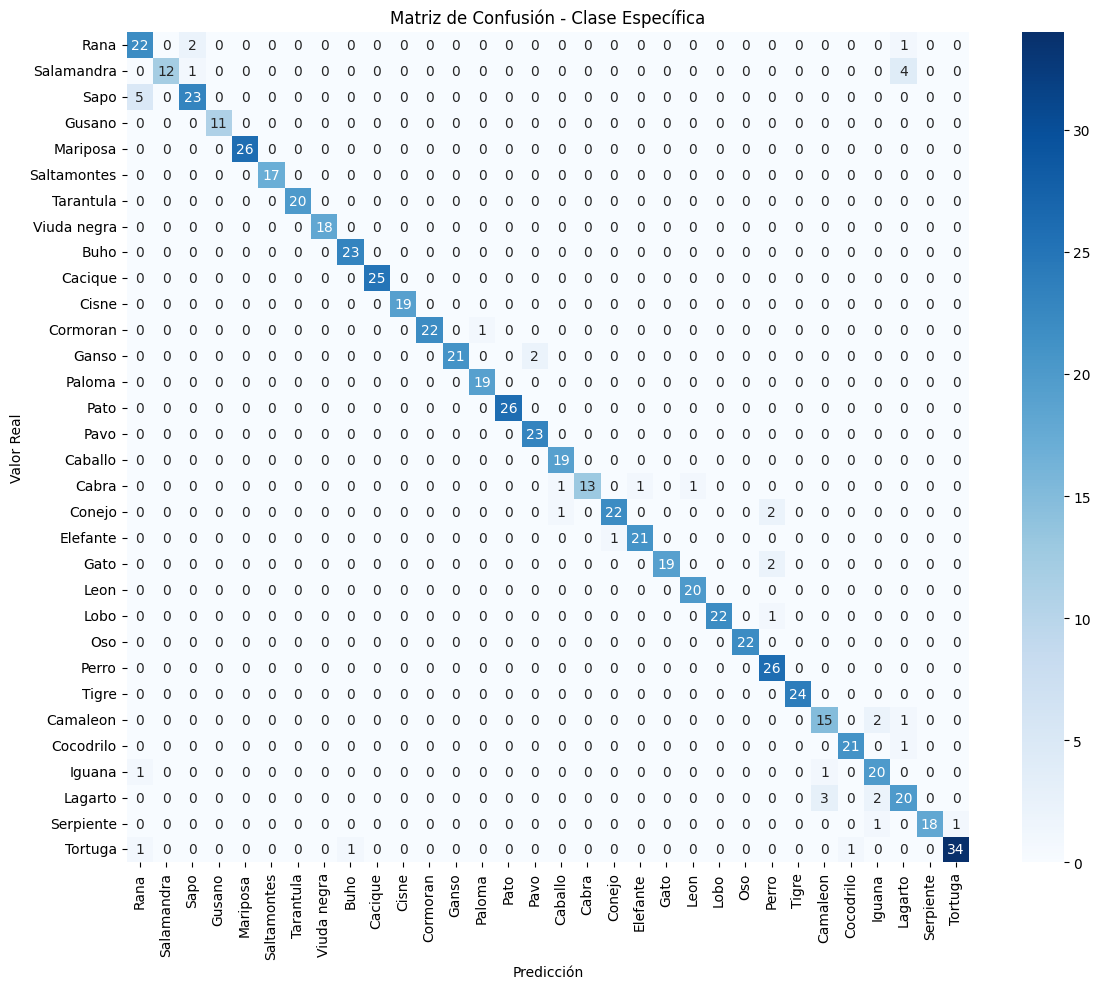

In [ ]:
#  nombres de clases específicas
class_names_esp = [class_dict[i + 5] for i in range(32)]

plot_confusion(y_true_esp, y_pred_esp, title="Matriz de Confusión - Clase Específica", class_names=class_names_esp)

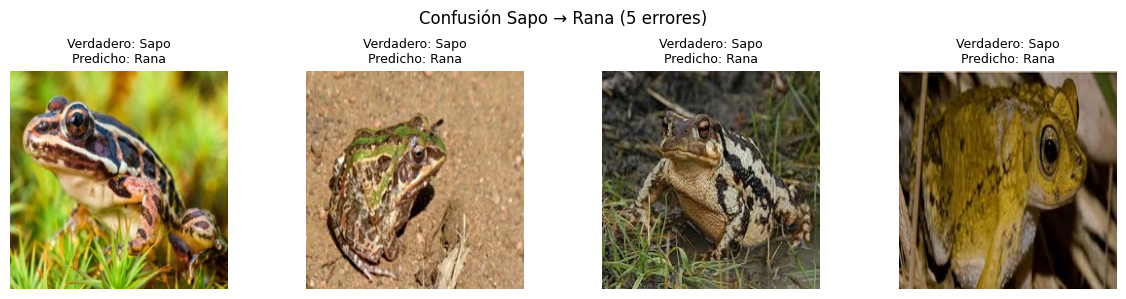

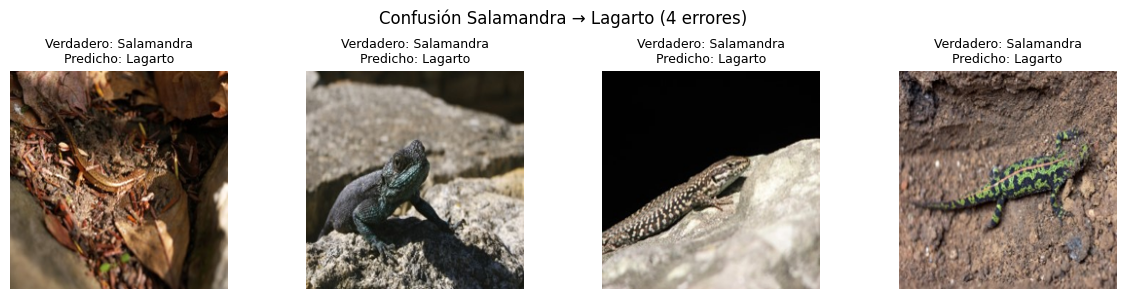

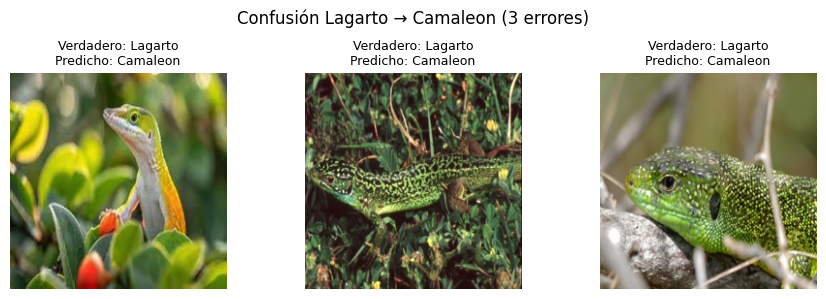

In [ ]:
#@title Ejemplos imágenes confundidas para la clase más específica

#  Matriz de confusion solo errores
cm = confusion_matrix(y_true_esp, y_pred_esp)
cm_errors = cm.copy()
np.fill_diagonal(cm_errors, 0)

# Selecciono los N pares con más errores
N_PARES = 3
parejas = []
for idx in cm_errors.flatten().argsort()[::-1]:
    if cm_errors.flatten()[idx] == 0:
        break                    # ya no quedan errores
    i, j = divmod(idx, cm_errors.shape[1])
    parejas.append((i, j))
    if len(parejas) == N_PARES:
        break

# ver los ejemplos
EJEMPLOS_POR_PAREJA = 4   # máximo de imágenes por confusión

for (verdadero, predicho) in parejas:
    idx_confundidos = np.where((y_true_esp == verdadero) & (y_pred_esp == predicho))[0]
    if len(idx_confundidos) == 0:
        continue

    seleccion = np.random.choice(
        idx_confundidos,
        size=min(EJEMPLOS_POR_PAREJA, len(idx_confundidos)),
        replace=False
    )

    # figura
    cols = len(seleccion)
    fig, axs = plt.subplots(1, cols, figsize=(3 * cols, 3))

    for k, idx_val in enumerate(seleccion):
        fila = df_val.iloc[idx_val]
        img = cargar_imagen(fila['Id'], image_dir)

        axs[k].imshow(img)
        axs[k].axis('off')
        axs[k].set_title(
            f"Verdadero: {class_names_esp[verdadero]}\nPredicho: {class_names_esp[predicho]}",
            fontsize=9
        )

    plt.suptitle(
        f"Confusión {class_names_esp[verdadero]} → {class_names_esp[predicho]} "
        f"({len(idx_confundidos)} errores)",
        fontsize=12
    )
    plt.tight_layout()
    plt.show()


#### Conclusiones

- Los resultados muestran un rendimiento muy bueno del modelo, con una excelente distinción de clases; las confusiones se concentran en casos visualmente muy difíciles.  
- El ajuste progresivo de pesos entre pérdidas equilibró el aprendizaje y redujo las confusiones jerárquicas.  
- Congelar la ResNet-50 permitió un entrenamiento rápido y minimizó el sobreajuste, aprovechando buenas representaciones visuales.  
- Los errores remanentes se limitan a unos pocos pares de clases muy similares.
- Próximos pasos: generar más datos específicos para las clases con más problemas y/o aplicar un fine-tuning descongelando una de las capas de la Resnet.



#### Obtención de predicciones del conjunto de Test

Generación del archivo submission.csv

In [ ]:
def crear_dataset_test(df, image_dir):
    X = []
    nombres = []

    for _, fila in df.iterrows():
        img = cargar_imagen(fila['Id'], image_dir)
        tensor = imagen_tensor_resnet(img)
        X.append(tensor)
        nombres.append(fila['Id'])

    X = tf.stack(X)
    return X, nombres

#Cargar archivos
df_test = pd.read_csv("test.csv")
df_example = pd.read_csv("submission_example.csv")

# === Preprocesar test ===
X_test, nombres = crear_dataset_test(df_test, image_dir="test")
ds_test = crear_tf_dataset(X_test, y_tuple=(X_test, X_test), shuffle=False)  # dummy y para reutilizar función

# === Predicción ===
pred_gen, pred_esp = modelo.predict(ds_test)
pred_clase_general = np.argmax(pred_gen, axis=1)
pred_clase_especifica = np.argmax(pred_esp, axis=1) + 5  # ajustar offset

# === Formato final ===
expected = [f"{g} {e}" for g, e in zip(pred_clase_general, pred_clase_especifica)]
df_submission = pd.DataFrame({
    "Id": nombres,
    "Expected": expected
})

# Asegurar mismo orden que submission_example
df_submission = df_submission.set_index("Id").reindex(df_example["Id"]).reset_index()

# Guardar archivo final
df_submission.to_csv("submission.csv", index=False)
print(" Archivo 'submission.csv' generado exitosamente.")

37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step
 Archivo 'submission.csv' generado exitosamente.
